In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ratings/sentiment_bert.csv
/kaggle/input/ratings/sentiment.csv


In [2]:
# !nvidia-smi

In [3]:
df = pd.read_csv('/kaggle/input/ratings/sentiment.csv')
df.head()

,index,book_id,user_id,review,title,rating,sentiment
0,1747,B000N6DDJQ,AUM3YMZ0YRJE0,"WHen I finally started reading this classic, I...",The Scarlet Letter A Romance,5.0,0.451157
1,1807,B000N6DDJQ,AMKZHBOK7VMQR,Hawthorne wrote a masterful work of historical...,The Scarlet Letter A Romance,5.0,0.636971
2,1820,B000N6DDJQ,AWLFVCT9128JV,I don't suppose anything can ruin a book more ...,The Scarlet Letter A Romance,4.0,0.481272
3,1829,B000N6DDJQ,ABN5K7K1TM1QA,"""All have sinned and fall short of the glory o...",The Scarlet Letter A Romance,5.0,0.495467
4,1830,B000N6DDJQ,A3IKBHODOTYYHM,I think the many readers who were forced to pa...,The Scarlet Letter A Romance,4.0,0.480073


In [4]:
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# stop_words = stopwords.words('english')

# porter = PorterStemmer()

In [5]:
# import re
# def clean_text(words):
#     """The function to clean text"""
#     words = re.sub("[^a-zA-Z]"," ", words)
#     text = words.lower().split()                   
#     return " ".join(text)

# def remove_stopwords(text):
#     """The function to removing stopwords"""
#     text = [word.lower() for word in text.split() if word.lower() not in stop_words]
#     return " ".join(text)

# def stemmer(stem_text):
#     """The function to apply stemming"""
#     stem_text = [porter.stem(word) for word in stem_text.split()]
#     return " ".join(stem_text)

In [6]:
# df['review'] = df['review'].apply(clean_text)
# df['review'] = df['review'].apply(remove_stopwords)
# df['review'] = df['review'].apply(stemmer)

In [7]:
# import tensorflow as tf
# from transformers import BertTokenizer, TFBertModel

# # Load the pre-trained BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = TFBertModel.from_pretrained('bert-base-uncased')

# # Define a function to generate a sentiment score from a review using BERT
# def generate_sentiment_score(review):
#     # Tokenize the review text
#     inputs = tokenizer.encode_plus(review, add_special_tokens=True, return_tensors='tf')

#     # Pass the tokenized inputs through the BERT model to generate embeddings
#     outputs = model(inputs)
#     embeddings = outputs.last_hidden_state

#     # Compute a sentiment score by averaging the embeddings for each token
#     mean_embedding = tf.reduce_mean(embeddings, axis=1)
#     sentiment_score = tf.keras.layers.Dense(1, activation='sigmoid')(mean_embedding)

#     # Return the sentiment score as a float between 0 and 1
#     return float(sentiment_score.numpy())


In [8]:
# df['sentiment'] = df['review'].apply(lambda x: generate_sentiment_score(x))

In [9]:
df.head()

,index,book_id,user_id,review,title,rating,sentiment
0,1747,B000N6DDJQ,AUM3YMZ0YRJE0,"WHen I finally started reading this classic, I...",The Scarlet Letter A Romance,5.0,0.451157
1,1807,B000N6DDJQ,AMKZHBOK7VMQR,Hawthorne wrote a masterful work of historical...,The Scarlet Letter A Romance,5.0,0.636971
2,1820,B000N6DDJQ,AWLFVCT9128JV,I don't suppose anything can ruin a book more ...,The Scarlet Letter A Romance,4.0,0.481272
3,1829,B000N6DDJQ,ABN5K7K1TM1QA,"""All have sinned and fall short of the glory o...",The Scarlet Letter A Romance,5.0,0.495467
4,1830,B000N6DDJQ,A3IKBHODOTYYHM,I think the many readers who were forced to pa...,The Scarlet Letter A Romance,4.0,0.480073


In [10]:
df.to_csv('ratings.csv',index=False)

In [11]:
# df.drop(['index'],axis=1,inplace=True)

In [12]:
df = df.loc[~((df.rating.isin([1,2])) & (df['sentiment'] > 0.6))]
df = df.loc[~((df.rating.isin([4,5])) & (df['sentiment'] < 0.4))]

In [13]:
df.shape

(14355, 7)

In [14]:
from surprise import Dataset, Reader
from surprise import NMF, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [15]:
# Combine the rating and sentiment scores into a single score
df['hybrid_score'] = df['rating'] * df['sentiment']

In [16]:
# load data from a file
reader = Reader(line_format='user item rating', sep=',')

In [17]:
data = Dataset.load_from_df(df[['user_id', 'book_id', 'hybrid_score']], reader=reader)

In [18]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=.25)

In [19]:
raw_ratings = data.raw_ratings
raw_ratings[:5]

[('AUM3YMZ0YRJE0', 'B000N6DDJQ', 2.255786806344986, None),
 ('AMKZHBOK7VMQR', 'B000N6DDJQ', 3.1848567724227905, None),
 ('AWLFVCT9128JV', 'B000N6DDJQ', 1.9250879287719724, None),
 ('ABN5K7K1TM1QA', 'B000N6DDJQ', 2.477333843708038, None),
 ('A3IKBHODOTYYHM', 'B000N6DDJQ', 1.9202926158905027, None)]

In [20]:
# Train NMF model
model = NMF(n_factors=50, random_state=42)
model.fit(trainset)

In [21]:
# Evaluate the model on the test set
from surprise import accuracy
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.5054


In [22]:
import matplotlib.pyplot as plt
# %matplotlib.inline

rmse_lst = []

for i in range(10,70,10):
    model = NMF(n_factors=i,random_state=42)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    rmse_lst.append(rmse)

RMSE: 0.5277
RMSE: 0.5105
RMSE: 0.5059
RMSE: 0.5048
RMSE: 0.5054
RMSE: 0.5051


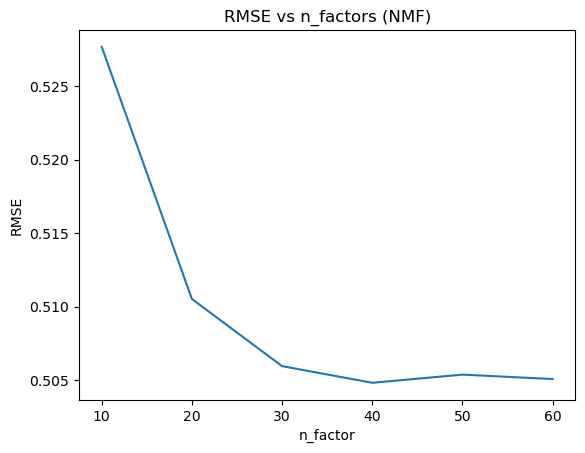

In [23]:
x = range(10,70,10)
y = rmse_lst

plt.plot(x, y)
plt.title('RMSE vs n_factors (NMF)')
plt.xlabel('n_factor')
plt.ylabel('RMSE')
plt.show()

In [24]:
from collections import defaultdict

In [25]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [26]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2)
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8491666666666671
0.5685036191295647


In [27]:
true_val = []
pred_val = []

for uid, _, true_r, est, _ in predictions:
    true_val.append(true_r)
    pred_val.append(est)

In [28]:
threshold = 2.5

In [29]:
# convert predicted scores to binary labels using the threshold
y_pred = [1 if score >= threshold else 0 for score in pred_val]
y_true = [1 if score >= threshold else 0 for score in true_val]

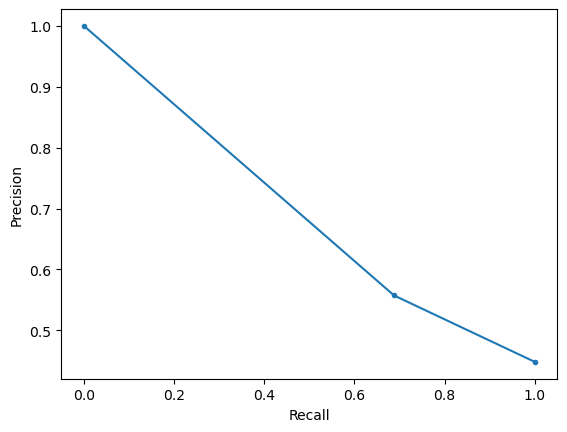

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [31]:
# Get the user ID for whom you want to make recommendations
user_id = 'AWLFVCT9128JV'

# Get the list of all items (books) in the dataset
items = df['book_id'].unique()

# Predict the rating the user would give to each item and store in a dictionary
item_ratings = {}
for item in items:
    predicted_rating = model.predict(user_id, item).est
    item_ratings[item] = predicted_rating

# Sort the items by predicted rating in descending order and select the top 5
top_items = sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 recommended books
for i, item in enumerate(top_items):
    print(f"{i+1}. {item[0]}({df[df['book_id']==item[0]].iloc[0].title}) with predicted rating of {item[1]:.2f}")

1. B000NLWCE8(The Martian Chronicles) with predicted rating of 2.99
2. B000NPRINY(All Creatures Great and Small) with predicted rating of 2.96
3. B000J5ZQH8(The Sea Wolf) with predicted rating of 2.96
4. B000BUZWWK(Alice in Wonderland and Through the Looking Glass) with predicted rating of 2.88
5. B000HEGYW2(East of Eden) with predicted rating of 2.88


In [32]:
# Train SVD model
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

In [33]:
# Evaluate the model on the test set
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.5198


In [34]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2)
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8049404761904767
0.5631376350178099
